In [191]:
#########################steps belowonly for testing reason ###############################
# Sampling function
def sampleFile(sample_size,df):
    df_new = df.sample(frac = (sample_size/100),random_state=42)
    return df_new

df = sampleFile(1,df)

In [192]:
len(df)

43286

In [182]:
features

,duration_in_minutes,Company,HOUR
10019694,6.00,Dispatch Taxi Affiliation,24
7792802,5.00,Dispatch Taxi Affiliation,23
7493958,6.32,Flash Cab,11
5984763,5.28,Nova Taxi Affiliation Llc,17
4498023,6.00,Northwest Management LLC,15
...,...,...,...
22209691,7.00,Globe Taxi,22
1557193,12.38,Nova Taxi Affiliation Llc,17
5281251,9.00,City Service,24
13237511,6.18,Yellow Cab,16


# Clustering

In [109]:
#install fuzzy library: 
    #pip install fuzzy-c-means

#import libraries 
import pandas as pd 
import numpy as np
import geopandas as gpd
from haversine import haversine, Unit
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from fcmeans import FCM
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from folium import folium, Marker
import warnings
warnings.filterwarnings("ignore")

#show all columns 
pd.set_option('display.max_columns', None)

In [190]:
#read in cleaned dataframe
df = pd.read_parquet("../data/df_cleaned_18_06_2021.parquet")

### 1. Data preparation
Now we prepare our data for the clustering and we define needed pre methods.

In [7]:
#function for adding wanted columns
def adding_column(df,keyword = None):
    if keyword == "distance city":
        df['PU_DISTANCE_CITY'] = df.apply(
        lambda row: haversine((row["Pickup Centroid Latitude"], row["Pickup Centroid Longitude"]), (41.85003, -87.65005), Unit.KILOMETERS), axis=1)
        df['DO_DISTANCE_CITY'] = df.apply(
        lambda row: haversine((row["Dropoff Centroid Latitude"], row["Dropoff Centroid Longitude"]), (41.85003, -87.65005), Unit.KILOMETERS), axis=1)
        return df
    if keyword == "dur":
        df["DURATION_IN_MINUTES"] = df["Trip Seconds"]/60
        df['DURATION_IN_MINUTES'] = df['DURATION_IN_MINUTES'].round(2)
        return df
    else: 
        print("No option selected!")

In [193]:
df = adding_column(df,"dur")
cluster_df = df[['DURATION_IN_MINUTES',"PU_HOUR"]].copy()
cluster_df.reset_index(drop=True, inplace=True)

### 2. Loss function method
Now we build a loss functions for our soft and hard clustering methods. 
We created one two functions for this purpose: 

#### get_amntcluster_soft
This method is for the determination of the number of clusters for soft clustering methods. 
We used the Partition Coefficient(PC) for the determination of the best amount of clusters. The PC is defined on a range from 0 to 1, with 1 being best. The metric shows us how cleanly our data is described by a certain model. 
The higher PC, the besser the amount of clusters. Note that we start with *two* clusters, not one. Clustering with only one center is a bad solution and will be by definition return PC = 1.

#### ge_amntcluster_hard
This method is for the determination of the number of clusters for hard clustering methods. 
It is just for our verification. We determine the loss for each amount of clusters and choose the number, which has the lowest loss. 

In [155]:
def get_amntcluster_soft(df, amnt_clusters,ctype):
    
    if ctype == "FUZZYC":
        #model list
        models = list()
        for i in range(0,amnt_clusters):
            fcm = FCM(i)
            fcm.fit(df)
            models.append(fcm)

        #list for partition coefficient
        pc = []

        rows = int(np.ceil(np.sqrt(amnt_clusters)))
        cols = int(np.ceil(amnt_clusters / rows))

        #calculate partition coefficient for every model
        for i in range(0,amnt_clusters):
            #add partition coeffient 
            pc.append(np.sum(models[i].u ** 2) / (models[i].n_samples))
        max_pc = -1
        index = -1
        for i in range(0,amnt_clusters):
            if i ==0:
                pass
            elif i==1:
                pass
            else:
                if (pc[i]>max_pc):
                    max_pc = pc[i]
                    index = i

        print("Best amount of clusters for Fuzzy Clustering: {}".format(index))
        print("Partition Coefficient for {} cluster: ".format(index),max_pc.round(2))
        plt.plot(np.r_[2:amnt_clusters+1], pc[1:])
    else: 
        raise Exception("ERROR\nSupported clustering methods:\n- FUZZY C\nPlease try again. ")


In [158]:
def get_amntcluster_hard(df, amnt_clusters,method = None):

    #scale data
    scaler = StandardScaler()
    scaler.fit(df)
    X_scaled = scaler.transform(df)
    X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)

    clusters = []
    losses = []
    for i in range(1, amnt_clusters):

        if (method == "KMEANS"):
            model = KMeans(n_clusters=i+1)
            model.fit(X_scaled)
            clusters.append(i+1)
            losses.append(model.inertia_)
            out = 'Clusterings completed: '+str(i+1)
            print(out, end='\r')
        else: 
            raise Exception('ERROR\nThe following hard clustering are supported:\n- KMEANS\nPlease choose one the supported methods.') 

    #plot loss for each number of clusters
    plt.figure(figsize=(10,5))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Loss')
    plt.title('Loss by Number of Clusters')
    plt.plot(clusters, losses)

### 3. Clustering methods
Now we build clustering methods. The first method is a 2d plotting function. 

In [159]:
#clustering method for all clustering methods
#currently working: FUZZYC (soft), KMEANS(hard)
def clustering_2d(ctype,amntClusters, df, xAxis, yAxis, name):
    
    #check if KMEANS
    if ctype == "KMEANS":
        km = KMeans(amntClusters)
        km.fit(df)
        km.predict(df)
        labels = km.labels_
        df['Cluster'] = labels 
    #check if FUZZYC
    elif ctype == "FUZZY C":
        fcm = FCM(amntClusters)
        fcm.fit(df)
        fcm.predict(df)
        labels = fcm.predict(df)
        df['Cluster'] = labels
    else: 
        raise Exception("ERROR\nSupported clustering methods:\n- KMEANS\n- FUZZY C\nPlease try again. ")
    
    #counting points in cluster
    clusteringData = pd.DataFrame(columns={'x', 'y', 'count', '%'}, index=np.arange(0, amntClusters))
    for i in range(0, amntClusters):
        #get point in middle of cluster i
        clusteringData.loc[i, 'x']=df[df['Cluster']==i][xAxis].mean()
        clusteringData.loc[i, 'y']=df[df['Cluster']==i][yAxis].mean()
        #get count of points in cluster i and percentage of points in cluster i compared to all clusters
        clusteringData.loc[i, 'count']=df[df['Cluster']==i][xAxis].count()
        clusteringData.loc[i, '%']=int(df[df['Cluster']==i][xAxis].count()/len(df)*100)
    
    #plotting
    plt.figure(1, figsize=(20,10))
    plt.scatter(df[xAxis], df[yAxis], c=labels.astype(np.float), edgecolor='none', s=100)
    #number of points in cluster
    for i in range(0, amntClusters):
        plt.annotate(str(clusteringData.loc[i, 'count'])+'('+str(clusteringData.loc[i, '%'])+'%)',
                     (clusteringData.loc[i, 'x'], clusteringData.loc[i, 'y']), fontsize=20, fontweight='bold')
    plt.xlabel(xAxis)
    plt.ylabel(yAxis)
    plt.title(ctype.title()+' for '+name)

### 4. Clustering
#### 1) Duration & Start Hours
#### Soft clustering: 
Now we also analyze our duration in minutes and our starting hours with soft clustring methods. Thereby we first use the FUZZY C Clustering method. First we determine the amount of clusters, based on the PC: 

In [194]:
cluster_df = df[['DURATION_IN_MINUTES',"PU_HOUR"]].copy()
cluster_df.reset_index(drop=True, inplace=True)

Best amount of clusters for Fuzzy Clustering: 2
Partition Coefficient for 2 cluster:  0.85


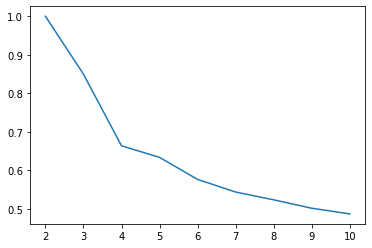

In [161]:
get_amntcluster_soft(cluster_df, 10,"FUZZYC")

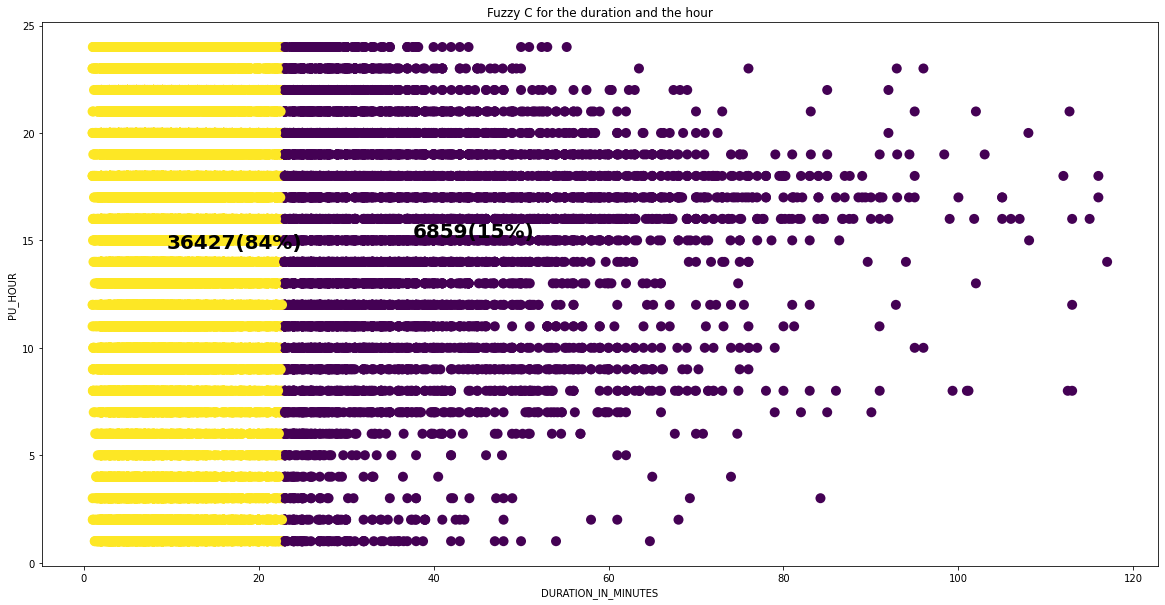

In [186]:
#FUZZY-C clustering plot for duration in minutes & PU_HOUR
clustering_2d("FUZZY C",2, cluster_df, "DURATION_IN_MINUTES", "PU_HOUR", "the duration and the hour")

####  Hard clustering:
First we validate our soft clustering approach FUZZY by the hard clustering method K-Means.

In [176]:
#optional step - removes all values which are bigger than 65 - the clusters looks better in this case 
cluster_df_red = cluster_df[(cluster_df['DURATION_IN_MINUTES'] <= 45)]

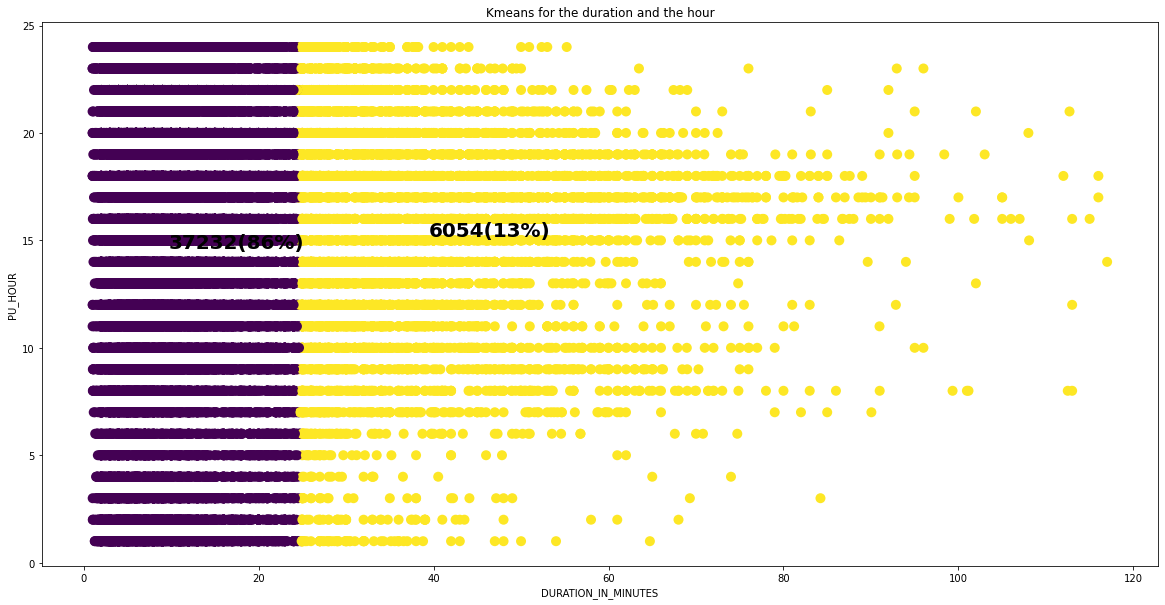

In [187]:
#KMEANS clustering plot for duration in minutes & PU_HOUR
clustering_2d("KMEANS",2, cluster_df, "DURATION_IN_MINUTES", "PU_HOUR", "the duration and the hour")

#### 2) Distance (Trip Miles) & Start hour
#### Soft Clustering: 

In [198]:
cluster_df = df[['Trip Miles',"PU_HOUR"]].copy()
cluster_df.reset_index(drop=True, inplace=True)

Best amount of clusters for Fuzzy Clustering: 2
Partition Coefficient for 2 cluster:  0.75


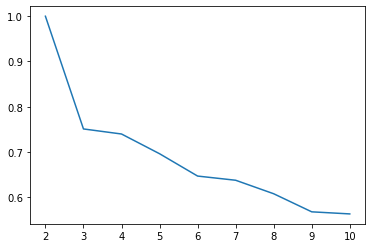

In [200]:
get_amntcluster_soft(cluster_df, 10,"FUZZYC")

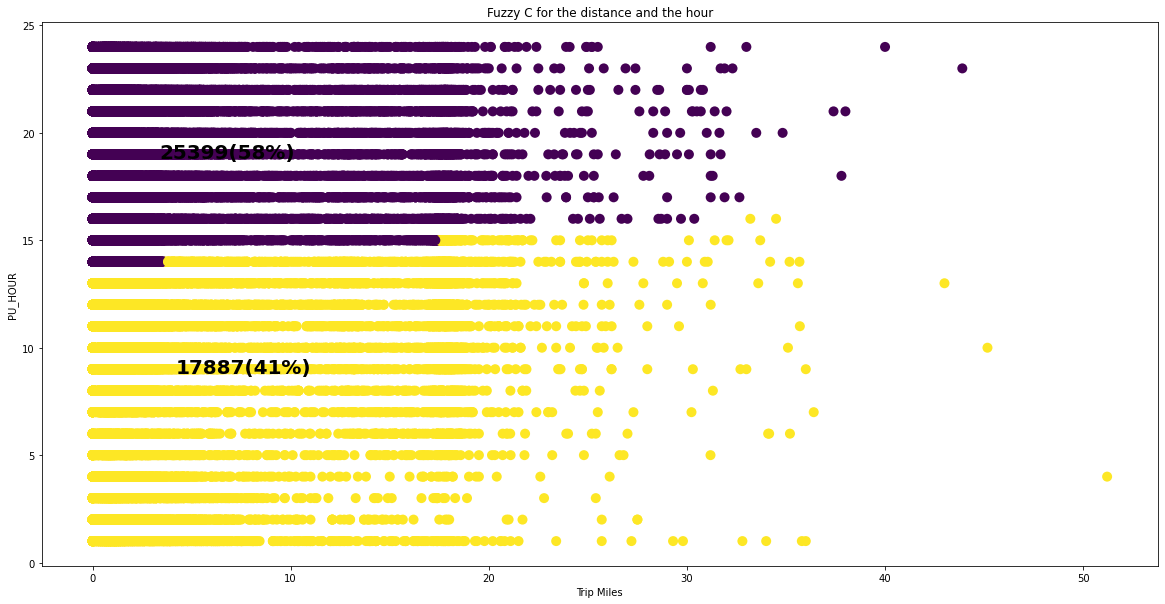

In [204]:
#FUZZY-C clustering plot for duration in minutes & PU_HOUR
clustering_2d("FUZZY C",2, cluster_df, "Trip Miles", "PU_HOUR", "the distance and the hour")